In [2]:
from cil.framework import DataContainer, BlockDataContainer, Partitioner

# Import libraries
  
from cil.optimisation.algorithms import SPDHG
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.functions import IndicatorBox, BlockFunction, L2NormSquared, MixedL21Norm
 
from cil.io import ZEISSDataReader
 
from cil.processors import Slicer, Binner, TransmissionAbsorptionConverter
 
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.ccpi_regularisation.functions import FGP_TV
 
from cil.utilities.display import show2D, show1D
 
 
import numpy as np
import matplotlib.pyplot as plt
import os



In [13]:
from cil.utilities import dataexample
from cil.plugins.astra.operators import ProjectionOperator

# get the data  
data = dataexample.SIMULATED_PARALLEL_BEAM_DATA.get()
data.reorder('astra')
data = data.get_slice(vertical='centre')

# create the geometries 
ag = data.geometry 
ig = ag.get_ImageGeometry()

# partition the data into batches contained in the elements of a BlockDataContainer
data_partitioned = data.partition(num_batches=10, mode='staggered') # Choose mode from `sequential`, `staggered` or `random_permutation` 
# From the partitioned data build a BlockOperator container the projectors for each batch 
A_partitioned = ProjectionOperator(ig, data_partitioned.geometry, device = "cpu")


print('The total number of angles is ', len(data.geometry.angles))
print('The first 30 angles are ', data.geometry.angles[:30])

print('In batch zero the number of angles is ', len(data_partitioned[0].geometry.angles))
print('The angles in batch zero are ', data_partitioned[0].geometry.angles)
print('The angles in batch one are ', data_partitioned[1].geometry.angles)


The total number of angles is  300
The first 30 angles are  [ 0.   1.2  2.4  3.6  4.8  6.   7.2  8.4  9.6 10.8 12.  13.2 14.4 15.6
 16.8 18.  19.2 20.4 21.6 22.8 24.  25.2 26.4 27.6 28.8 30.  31.2 32.4
 33.6 34.8]
In batch zero the number of angles is  30
The angles in batch zero are  [  0.  12.  24.  36.  48.  60.  72.  84.  96. 108. 120. 132. 144. 156.
 168. 180. 192. 204. 216. 228. 240. 252. 264. 276. 288. 300. 312. 324.
 336. 348.]
The angles in batch one are  [  1.2  13.2  25.2  37.2  49.2  61.2  73.2  85.2  97.2 109.2 121.2 133.2
 145.2 157.2 169.2 181.2 193.2 205.2 217.2 229.2 241.2 253.2 265.2 277.2
 289.2 301.2 313.2 325.2 337.2 349.2]


In [3]:
reader = ZEISSDataReader()
filename = '../data/valnut_tomo-A.txrm'
reader.set_up(file_name=filename)
data3D = reader.read()

# reorder data to match default order for Astra/Tigre operator
data3D.reorder('astra')

# Get Image and Acquisition geometries
ag3D = data3D.geometry
ig3D = ag3D.get_ImageGeometry()

# Extract vertical slice
data2D = data3D.get_slice(vertical='centre')

# Select every 10 angles
sliced_data = Slicer(roi={'angle':(0,1601,10)})(data2D)

# Reduce background regions
binned_data = Binner(roi={'horizontal':(120,-120,2)})(sliced_data)

# Create absorption data 
data = TransmissionAbsorptionConverter()(binned_data) 

# Remove circular artifacts
data -= np.mean(data.as_array()[80:100,0:30])

# Get Image and Acquisition geometries for one slice
ag2D = data.geometry
ag2D.set_angles(ag2D.angles, initial_angle=0.2, angle_unit='radian')
ig2D = ag2D.get_ImageGeometry()

A = ProjectionOperator(ig2D, ag2D, device = "gpu")

#show2D(data)

(161, 392)


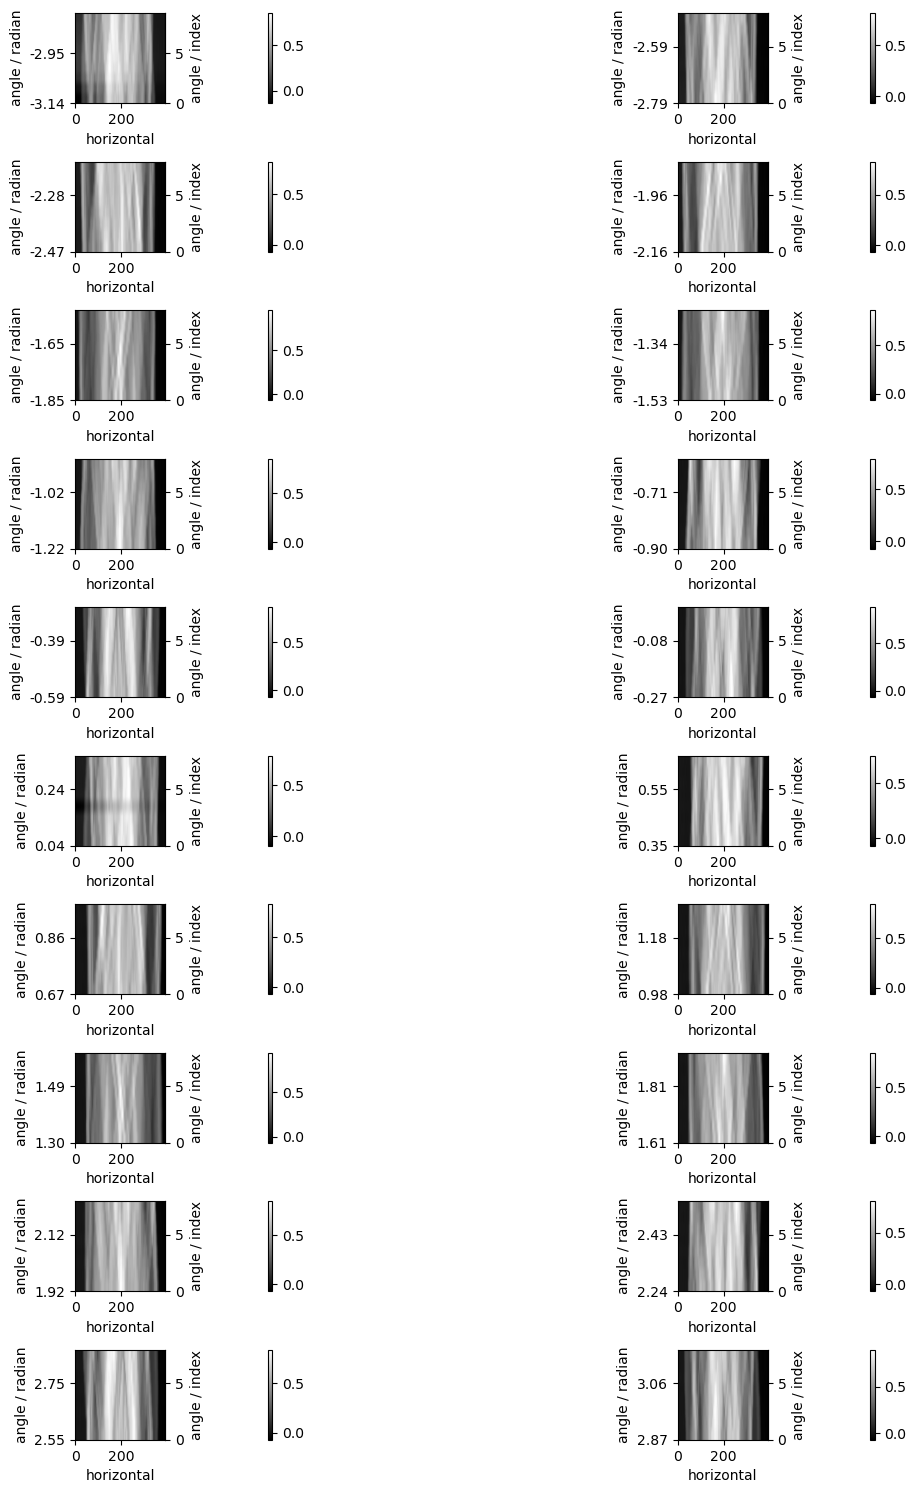

In [4]:
n_subsets = 20
print(data.shape)

partitioned_data=data.partition(n_subsets, 'sequential')
show2D(partitioned_data)

In [5]:
# Define number of subsets
print(data.shape)
n_subsets = 161
partitioned_data=data.partition(n_subsets, 'sequential')
print(partitioned_data.shape)

(161, 392)
(161, 1)


(161, 392)


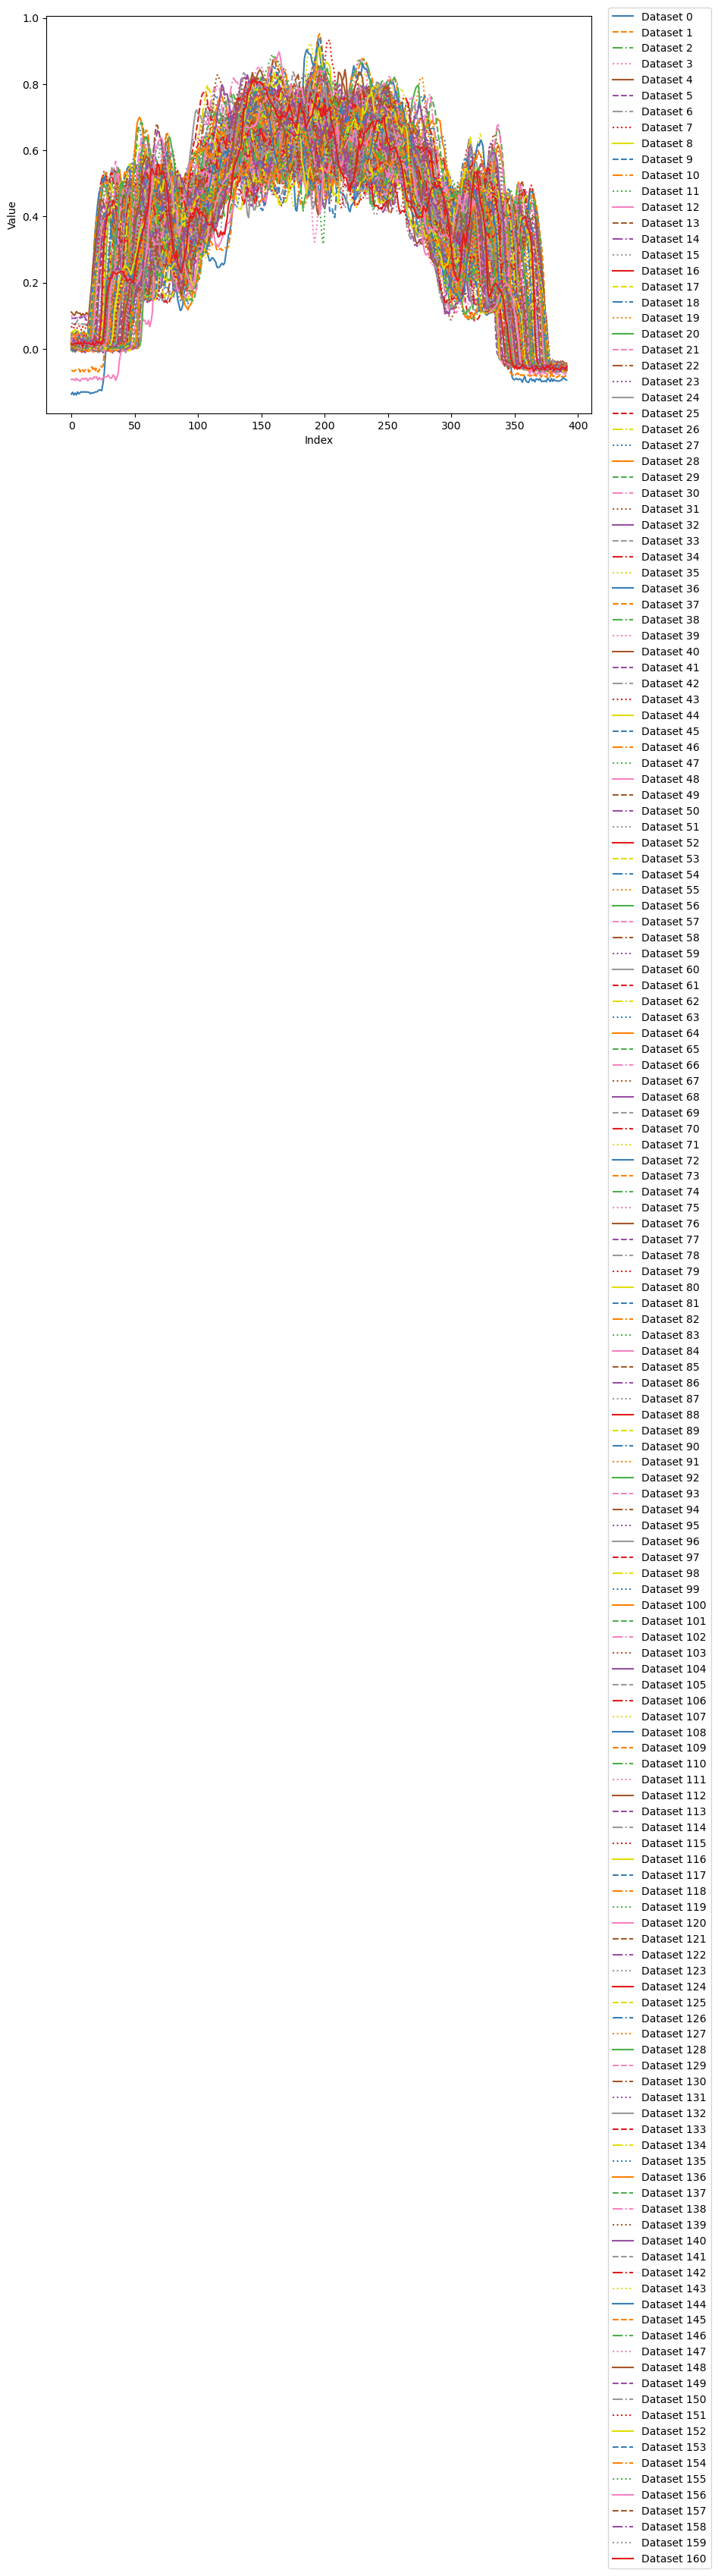

In [6]:


show1D(partitioned_data)

print(data.shape)


In [7]:

# Initialize the lists containing the F_i's and A_i's
f_subsets = []


# Define F_i's 
for i in range(n_subsets):
    # Define F_i and put into list
    fi = 0.5*L2NormSquared(b = partitioned_data[i])
    f_subsets.append(fi)
    
    
ageom_subset = partitioned_data.geometry
A = ProjectionOperator(ig2D, ageom_subset)

#F = L2NormSquared.fromBlockDataContainer(partitioned_data, constant=0.5)

# Define F and K
F = BlockFunction(*f_subsets)
K = A

# Define G (by default the positivity constraint is on)
alpha = 0.025
G = alpha * FGP_TV()

In [8]:
print(ageom_subset)
print(A)
print(A.shape[0])

161
